### 注
codonW出来的blk结果两列的数值分别表示，密码子出现次数和RSCU值.

#### 最优密码子分析
根据ΔRSCU法[15]预测最优密码子，将基因按ENC值大小排序，取两端10%（or 5%）的基因(5个基因)组成高(低ENC值)、低样本组。比较2组密码子的RSCU值：若差异ΔRSCU> 0.08，且该密码子的RSCU值在高样本组中大于1而在低样本组中小于1，即确定为最优密码子。

（1）先通过codonW计算得到某个物种的所有CDS的ENc值，然后得到高低两个样本组的CDS；

（2）将这些CDS序列拿出来分别放到两个文件中，代表高低组；

（3）将高低组的序列文件分别通过emboss的cusp功能计算得到高低组的各个密码子的RSCU；

（4）然后通过比较高低组相同密码子的ΔRSCU（>0.08）和RSCU值(高组>1,低组<1)来确定最优密码子。

多个物种可分别通过此方法得到不同物种的最优密码子。

### 计算整个物种密码子的RSCU和RFSC

In [3]:
import os
import pandas as pd
import numpy as np

In [2]:
indir = 'RSCU'
files = [os.path.join(indir, f) for f in os.listdir(indir) if f.endswith('txt')]
files

['RSCU/Miscanthus_floridulus.txt',
 'RSCU/Miscanthus_giganteus.txt',
 'RSCU/Miscanthus_sacchariflorus.txt',
 'RSCU/Miscanthus_sinensis.txt',
 'RSCU/Miscanthus_transmorrisonensis.txt',
 'RSCU/Saccharum_spontaneum.txt',
 'RSCU/Sorghum_bicolor.txt']

In [3]:
def high_freq(df):
    """判断高频密码子：
    （1）某一个密码子的RFSC>60%; 
    （2）某一个密码子的RFSC超过其对应氨基酸的同义密码子平均频率的0.5倍.
    """
    aa = []
    codons = []
    sysn_mean_freq = []
    for idx, row in df.iterrows():
        aa.append(row['Amino_acid'])
        codons.append(row['Codon'])
        mean_freq = df[(df.Amino_acid==row['Amino_acid']) & \
                       (df.Codon!=row['Codon'])]['RFSC'].mean()
        sysn_mean_freq.append(mean_freq)
        
        
    df_mean_freq = pd.DataFrame({'Amino_acid': aa, 
                                 'Codon': codons,
                                 'RFSC_mean':sysn_mean_freq})
    df = df.merge(df_mean_freq, on=['Amino_acid', 'Codon'], how='inner')
    df['is_hf'] = 0
    df.loc[(df.RFSC>0.6) | (df.RFSC>df.RFSC_mean*1.5), 'is_hf'] = 1
    # print(df.head())
    df.drop(columns=['RFSC_mean'], inplace=True)
    
    hf = df[df.is_hf==1]
    print('High Frequency Codon Numbers: ', len(hf))
    return df
    


def cal_rscu(infile):
    """infile可从http://www.bioinformatics.nl/emboss-explorer/ 网站中的cusp功能得到.
    """
    df = pd.read_csv(infile, comment='#', header=0, delimiter=r"\s+")
    # 计算RSCU公式的分母
    df_aa_mean = df.groupby('AA')['Number'].mean().reset_index()
    df_aa_mean.columns = ['AA', 'avg_codon_num']
    
    df_merge = df.merge(df_aa_mean, on='AA', how='inner')
    # 编码氨基酸的某密码子数量除以均值就等于RSCU
    df_merge['rscu'] = df_merge['Number']/df_merge['avg_codon_num']
    
    # 生成氨基酸简称的对应关系
    aa_tri = ['Gly', 'Ala', 'Val', 'Leu', 'Ile', 'Pro', 'Phe', 'Tyr', 'Trp', 'Ser', 
              'Thr', 'Cys', 'Met', 'Asn', 'Gln', 'Asp', 'Glu', 'Lys', 'Arg', 'His', 'Ter']
    aa_sing = ['G', 'A', 'V', 'L', 'I', 'P', 'F', 'Y', 'W', 'S', 'T', 'C', 'M', 'N', 'Q', 
               'D', 'E', 'K', 'R', 'H', '*']
    df_amino = pd.DataFrame({'AA_tri':aa_tri, 'AA':aa_sing}).sort_values(by='AA')
    df_merge = df_merge.merge(df_amino, on='AA', how='inner')

    # 重命名列名并选择要输出的列
    df_merge.columns = ['Codon', 'AA', 'RFSC', 'Frequency(*1000)', 
                        'Number', 'avg_codon_num', 'RSCU', 'Amino_acid']
    
    df_merge = df_merge[['Amino_acid', 'AA', 'Codon', 'Number', 'Frequency(*1000)', 'RFSC', 'RSCU']]
    bias_codons = df_merge[df_merge['RSCU']>1]
    print('Bias Codon Numbers (RSCU>1): ', len(bias_codons))
    
    return df_merge[['Amino_acid', 'Codon', 'Number', 'RSCU', 'RFSC']]


In [64]:
writer = pd.ExcelWriter('Step2_RSCU_RFSC.xlsx', engine='xlsxwriter')

dfs = []
for idx, f in enumerate(files):
    species = f.split('/')[-1].split('.')[0]
    print('\n')
    print(species)
    df = cal_rscu(f)
    df.to_excel(writer, sheet_name=species, index=False)
    df = high_freq(df)
    df.columns = ['Amino_acid', 'Codon', 'Number_'+str(idx), 'RSCU_'+str(idx), 
                  'RFSC_'+str(idx), 'is_hf_'+str(idx)]
    dfs.append(df)
    

writer.save()



Miscanthus_floridulus
Bias Codon Numbers (RSCU>1):  32
High Frequency Codon Numbers:  22


Miscanthus_giganteus
Bias Codon Numbers (RSCU>1):  31
High Frequency Codon Numbers:  22


Miscanthus_sacchariflorus
Bias Codon Numbers (RSCU>1):  31
High Frequency Codon Numbers:  21


Miscanthus_sinensis
Bias Codon Numbers (RSCU>1):  31
High Frequency Codon Numbers:  21


Miscanthus_transmorrisonensis
Bias Codon Numbers (RSCU>1):  32
High Frequency Codon Numbers:  22


Saccharum_spontaneum
Bias Codon Numbers (RSCU>1):  31
High Frequency Codon Numbers:  23


Sorghum_bicolor
Bias Codon Numbers (RSCU>1):  31
High Frequency Codon Numbers:  23


In [65]:
dfa = dfs[0].merge(dfs[1], on=['Amino_acid', 'Codon'], how='inner')\
            .merge(dfs[2], on=['Amino_acid', 'Codon'], how='inner')\
            .merge(dfs[3], on=['Amino_acid', 'Codon'], how='inner')\
            .merge(dfs[4], on=['Amino_acid', 'Codon'], how='inner')\
            .merge(dfs[5], on=['Amino_acid', 'Codon'], how='inner')\
            .merge(dfs[6], on=['Amino_acid', 'Codon'], how='inner')
dfa.head(2)

,Amino_acid,Codon,Number_0,RSCU_0,RFSC_0,is_hf_0,Number_1,RSCU_1,RFSC_1,is_hf_1,...,RFSC_4,is_hf_4,Number_5,RSCU_5,RFSC_5,is_hf_5,Number_6,RSCU_6,RFSC_6,is_hf_6
0,Ala,GCA,348,1.158070,0.290,0,353,1.177648,0.294,0,...,0.291,0,317,1.197356,0.299,0,318,1.162706,0.291,0
1,Ala,GCC,189,0.628952,0.157,0,186,0.620517,0.155,0,...,0.156,0,157,0.593012,0.148,0,165,0.603291,0.151,0


In [66]:
dfa_bias = dfa[(dfa.RSCU_0>1) & (dfa.RSCU_1>1) & (dfa.RSCU_2>1) & (dfa.RSCU_3>1) \
                & (dfa.RSCU_4>1) & (dfa.RSCU_5>1) & (dfa.RSCU_6>1)]
dfa_bias.shape

(30, 30)

In [67]:
bias_codons = list(dfa_bias['Codon'])
AT_end = [i for i in bias_codons if i.endswith(('A', 'T'))]
len(AT_end)

28

In [68]:
dfa[(dfa.is_hf_0==1) & (dfa.is_hf_1==1) & (dfa.is_hf_2==1) & (dfa.is_hf_3==1) & \
    (dfa.is_hf_4==1) & (dfa.is_hf_5==1) & (dfa.is_hf_6==1)].shape

(21, 30)

In [34]:
dfa_hf = dfa[dfa]

0.9333333333333333

In [11]:
348/((530+348+189+135))

0.2895174708818636

In [12]:
sum(df['Number'])

19611

In [13]:
348/19611

0.017745143031971854

In [17]:
(530+348+189+135)/4

300.5

In [37]:
528/(528+182+336+126)

0.45051194539249145

### 计算最优密码子
#### 1、根据ENc将CDS分组

In [84]:
cds_dir = 'filtered_data'
enc_dir = 'ENc'
cds_files = sorted([os.path.join(cds_dir, f) for f in os.listdir(cds_dir) 
                    if f.endswith('.txt')])
# 保持enc和cds文件顺序的一致
enc_files = sorted([os.path.join(enc_dir, f.split('.')[0]+'.out') 
                    for f in os.listdir(cds_dir) if f.endswith('.txt')])
print(cds_files)
enc_files

['filtered_data/Miscanthus_floridulus.txt', 'filtered_data/Miscanthus_giganteus.txt', 'filtered_data/Miscanthus_sacchariflorus.txt', 'filtered_data/Miscanthus_sinensis.txt', 'filtered_data/Miscanthus_transmorrisonensis.txt', 'filtered_data/Saccharum_spontaneum.txt', 'filtered_data/Sorghum_bicolor.txt']


['ENc/Miscanthus_floridulus.out',
 'ENc/Miscanthus_giganteus.out',
 'ENc/Miscanthus_sacchariflorus.out',
 'ENc/Miscanthus_sinensis.out',
 'ENc/Miscanthus_transmorrisonensis.out',
 'ENc/Saccharum_spontaneum.out',
 'ENc/Sorghum_bicolor.out']

In [85]:
def get_cds(cds_file):
    """过滤后的CDS文件
    """
    seq_name = []
    cds = []
    with open(cds_file) as f:
        for line in f:
            if line.startswith('>'):
                name = line.strip().split()[0]
                seq_name.append(name)
            else:
                seq = line.strip()
                cds.append(seq)
    df = pd.DataFrame({'name':seq_name, 'cds':cds})
    
    return df


def split_cds_by_enc(enc_file, df_cds):
    """获取高低ENc密码子的cds
    """
    df = pd.read_csv(enc_file, sep='\t', header=0)
    num = int(len(df)*0.05)
    df = pd.concat([df, df_cds], axis=1).sort_values(by='Nc', ascending=True)
    df_high_enc = df.tail(num)[['name', 'cds']]
    df_low_enc = df.head(num)[['name', 'cds']]
    
    return df_high_enc, df_low_enc


def write_fasta(df, outfile):
    """写出高低两组cds
    """
    with open(outfile, 'wt') as f:
        for idx, row in df.iterrows():
            name = row['name']
            seq = row['cds']
            f.write(name+'\n')
            f.write(seq+'\n')
        

In [86]:
outdir = 'RSCU/groupped_by_enc/'
if not os.path.exists(outdir):
    os.makedirs(outdir)

for encf, cdsf in zip(enc_files, cds_files):
    species = cdsf.split('/')[-1].split('.')[0]
    print(species)
    df_cds = get_cds(cdsf)
    df_high_enc, df_low_enc = split_cds_by_enc(encf, df_cds)
    write_fasta(df_high_enc, os.path.join(outdir, species+'.high.fasta'))
    write_fasta(df_low_enc, os.path.join(outdir, species+'.low.fasta'))
    print(species+'.high.cusp')
    print(species+'.low.cusp')
    print('\n')
    

Miscanthus_floridulus
Miscanthus_floridulus.high.cusp
Miscanthus_floridulus.low.cusp


Miscanthus_giganteus
Miscanthus_giganteus.high.cusp
Miscanthus_giganteus.low.cusp


Miscanthus_sacchariflorus
Miscanthus_sacchariflorus.high.cusp
Miscanthus_sacchariflorus.low.cusp


Miscanthus_sinensis
Miscanthus_sinensis.high.cusp
Miscanthus_sinensis.low.cusp


Miscanthus_transmorrisonensis
Miscanthus_transmorrisonensis.high.cusp
Miscanthus_transmorrisonensis.low.cusp


Saccharum_spontaneum
Saccharum_spontaneum.high.cusp
Saccharum_spontaneum.low.cusp


Sorghum_bicolor
Sorghum_bicolor.high.cusp
Sorghum_bicolor.low.cusp




### 2、计算两组CDS的RSCU

In [91]:
cusp_dir = 'RSCU/groupped_by_enc/RSCU/'
cusp_files = sorted([os.path.join(cusp_dir, f) for f in os.listdir(cusp_dir) 
                        if f.endswith('cusp')])
cusp_files

['RSCU/groupped_by_enc/RSCU/Miscanthus_floridulus.high.cusp',
 'RSCU/groupped_by_enc/RSCU/Miscanthus_floridulus.low.cusp',
 'RSCU/groupped_by_enc/RSCU/Miscanthus_giganteus.high.cusp',
 'RSCU/groupped_by_enc/RSCU/Miscanthus_giganteus.low.cusp',
 'RSCU/groupped_by_enc/RSCU/Miscanthus_sacchariflorus.high.cusp',
 'RSCU/groupped_by_enc/RSCU/Miscanthus_sacchariflorus.low.cusp',
 'RSCU/groupped_by_enc/RSCU/Miscanthus_sinensis.high.cusp',
 'RSCU/groupped_by_enc/RSCU/Miscanthus_sinensis.low.cusp',
 'RSCU/groupped_by_enc/RSCU/Miscanthus_transmorrisonensis.high.cusp',
 'RSCU/groupped_by_enc/RSCU/Miscanthus_transmorrisonensis.low.cusp',
 'RSCU/groupped_by_enc/RSCU/Saccharum_spontaneum.high.cusp',
 'RSCU/groupped_by_enc/RSCU/Saccharum_spontaneum.low.cusp',
 'RSCU/groupped_by_enc/RSCU/Sorghum_bicolor.high.cusp',
 'RSCU/groupped_by_enc/RSCU/Sorghum_bicolor.low.cusp']

In [119]:
def calc_opt_codon(df_high, df_low):
    """通过ENc高低两组的RSCU对比得到最优密码子
    """
    df_high.columns = ['Amino_acid', 'Codon', 'Number', 'RSCU_high', 'RFSC_high']
    df_low.columns = ['Amino_acid', 'Codon', 'Number', 'RSCU_low', 'RFSC_low']
    df = df_high[['Amino_acid', 'Codon', 'RSCU_high']].merge(
                    df_low[['Amino_acid', 'Codon', 'RSCU_low']], 
                    on=['Amino_acid', 'Codon'],
                    how='inner')
    df['RSCU_diff'] = abs(df['RSCU_high'] - df['RSCU_low'])
    df['is_opt'] = 0
    df.loc[(df['RSCU_diff']>0.08) & (df['RSCU_high']>1) & (df['RSCU_low']<1), 'is_opt'] = 1
    opt_codons = list(df[df['is_opt']==1]['Codon'])
    print('Optimal Codons numbers: ', len(opt_codons))
    print(opt_codons)
    return df, opt_codons
    

In [120]:
opt_set = []

for idx in range(0, len(cusp_files), 2):
    species = cusp_files[idx].split('/')[-1].split('.')[0]
    print(species)
    high = cal_rscu(cusp_files[idx])
    low = cal_rscu(cusp_files[idx+1])
    df, opt_codons = calc_opt_codon(high, low)
    opt_set.append(set(opt_codons))
    print('\n')

Miscanthus_floridulus
Bias Codon Numbers (RSCU>1):  28
Bias Codon Numbers (RSCU>1):  30
Optimal Codons numbers:  4
['CAC', 'CCA', 'TCA', 'TAG']


Miscanthus_giganteus
Bias Codon Numbers (RSCU>1):  28
Bias Codon Numbers (RSCU>1):  30
Optimal Codons numbers:  6
['TTC', 'CTT', 'CCA', 'AGG', 'TCA', 'TGA']


Miscanthus_sacchariflorus
Bias Codon Numbers (RSCU>1):  28
Bias Codon Numbers (RSCU>1):  29
Optimal Codons numbers:  4
['GCC', 'CTT', 'AGG', 'ACG']


Miscanthus_sinensis
Bias Codon Numbers (RSCU>1):  32
Bias Codon Numbers (RSCU>1):  27
Optimal Codons numbers:  11
['GCC', 'TTC', 'GGC', 'ATA', 'CTA', 'AGA', 'AGG', 'TCT', 'ACC', 'ACG', 'GTC']


Miscanthus_transmorrisonensis
Bias Codon Numbers (RSCU>1):  27
Bias Codon Numbers (RSCU>1):  30
Optimal Codons numbers:  4
['CTT', 'CCA', 'TCA', 'TGA']


Saccharum_spontaneum
Bias Codon Numbers (RSCU>1):  30
Bias Codon Numbers (RSCU>1):  30
Optimal Codons numbers:  4
['CTT', 'CCA', 'TCA', 'TAG']


Sorghum_bicolor
Bias Codon Numbers (RSCU>1):  29
Bia

In [121]:
opt_set

[{'CAC', 'CCA', 'TAG', 'TCA'},
 {'AGG', 'CCA', 'CTT', 'TCA', 'TGA', 'TTC'},
 {'ACG', 'AGG', 'CTT', 'GCC'},
 {'ACC', 'ACG', 'AGA', 'AGG', 'ATA', 'CTA', 'GCC', 'GGC', 'GTC', 'TCT', 'TTC'},
 {'CCA', 'CTT', 'TCA', 'TGA'},
 {'CCA', 'CTT', 'TAG', 'TCA'},
 {'ACA', 'ATA', 'CAT', 'GCC', 'GGA', 'TAG', 'TCA', 'TGA'}]

In [122]:
opt_set[0]&opt_set[1]& opt_set[2]& opt_set[3]& opt_set[4]& opt_set[5]& opt_set[6]

set()

In [123]:
opt_set[0]&opt_set[1]& opt_set[2]& opt_set[3]& opt_set[4]

set()

### 可视化密码子数量

In [4]:
indir = 'RSCU'
cuspfiles = sorted([os.path.join(indir, f) for f in os.listdir(indir) if f.endswith('txt')])
cuspfiles

['RSCU/Miscanthus_floridulus.txt',
 'RSCU/Miscanthus_giganteus.txt',
 'RSCU/Miscanthus_sacchariflorus.txt',
 'RSCU/Miscanthus_sinensis.txt',
 'RSCU/Miscanthus_transmorrisonensis.txt',
 'RSCU/Saccharum_spontaneum.txt',
 'RSCU/Sorghum_bicolor.txt']

In [7]:
from collections import defaultdict 

aa_tri = ['Gly', 'Ala', 'Val', 'Leu', 'Ile', 'Pro', 'Phe', 'Tyr', 'Trp', 'Ser', 
          'Thr', 'Cys', 'Met', 'Asn', 'Gln', 'Asp', 'Glu', 'Lys', 'Arg', 'His', 'Ter']
# aa_tri = [i.upper() for i in aa_tri]
aa_sing = ['G', 'A', 'V', 'L', 'I', 'P', 'F', 'Y', 'W', 'S', 'T', 'C', 'M', 'N', 'Q', 
           'D', 'E', 'K', 'R', 'H', '*']
aa_map = {s:tri for s, tri in zip(aa_sing, aa_tri)}

cunts = []

for f in cuspfiles:
    codons_num = defaultdict(dict)
    df = pd.read_csv(f, comment='#', header=0, delimiter=r"\s+")
    for idx, row in df.iterrows():
        codons_num[aa_map[row['AA']]][row['Codon']] = row['Number']
    cunts.append(codons_num)

<Figure size 1000x800 with 0 Axes>

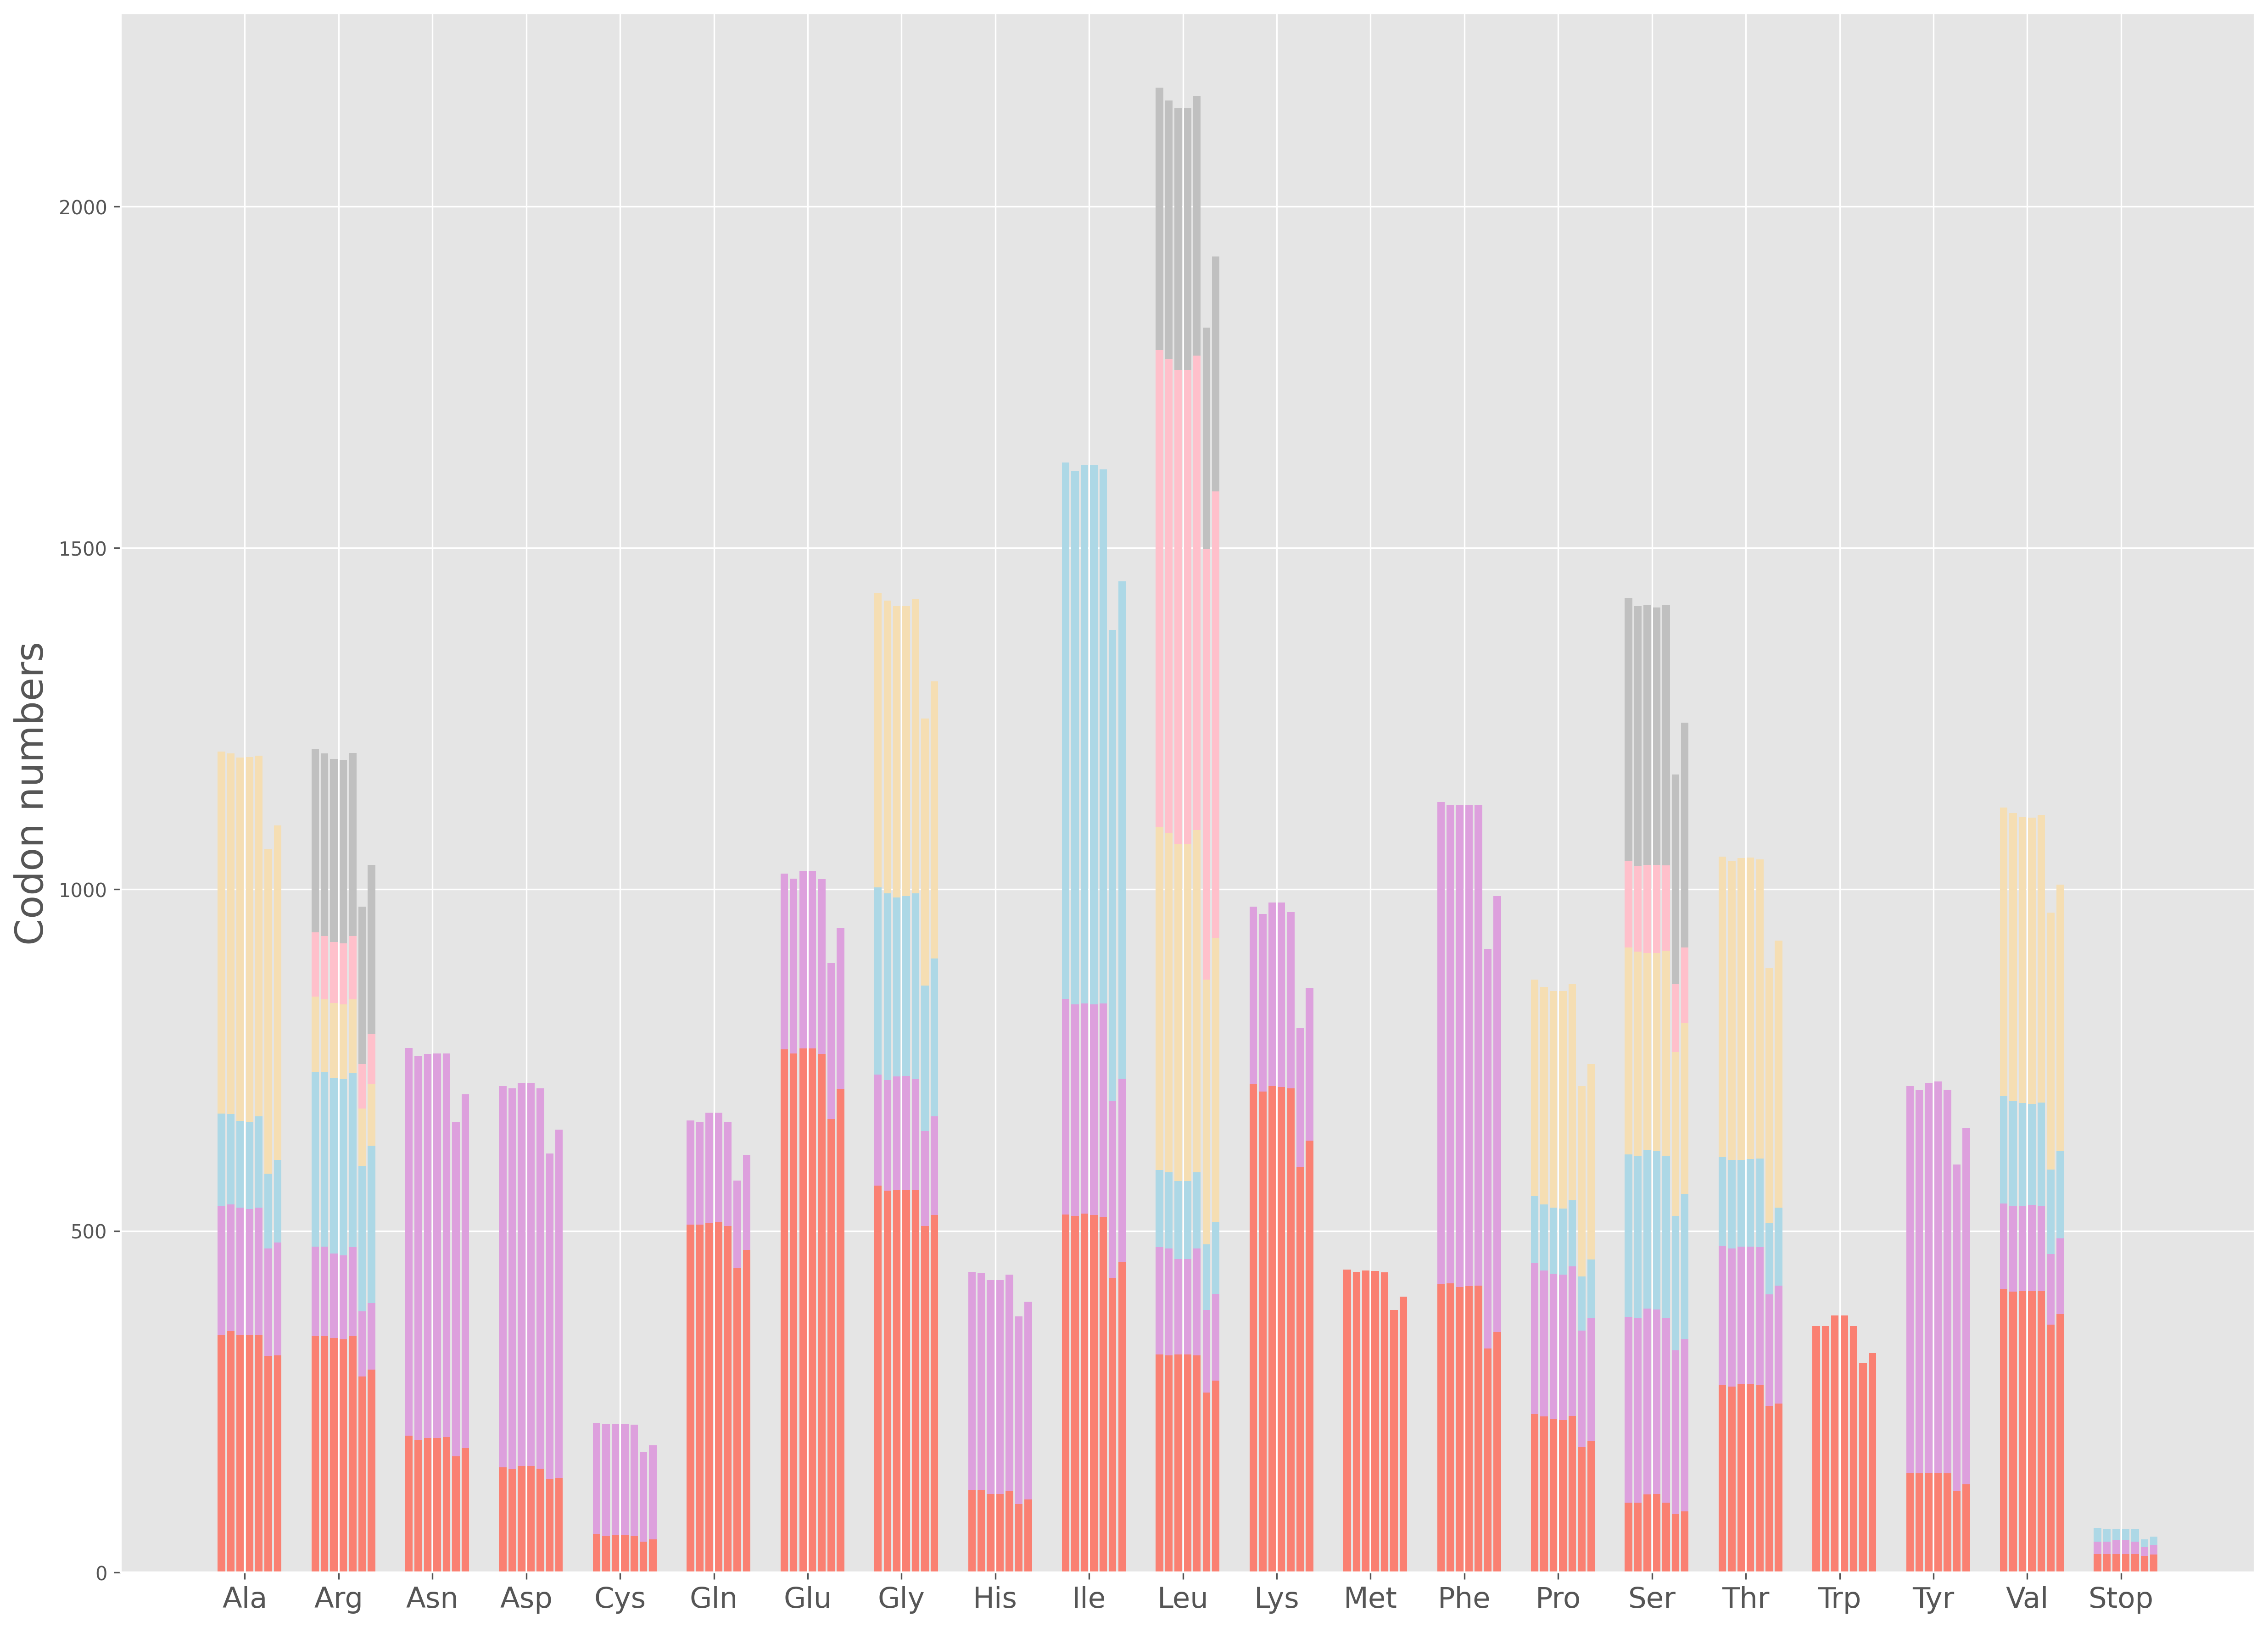

In [14]:
import matplotlib.pyplot as plt
import matplotlib.font_manager
plt.style.use('ggplot')
plt.figure(figsize=(10,8), dpi=100)

cunt1 = cunts[0]

labels = sorted(cunt1.keys())
labels.remove('Ter')
labels.append('Ter')

xticks = np.arange(0, len(list(cunt1.keys())))
#labels = set()
font2 = {
    'family': 'Times New Roman',
    'weight': 'normal',
    'size': 20,
}
plt.figure(dpi=300, figsize=(20, 15))
wid = 0.08  #'orangered'
colors = dict([(0, 'salmon'), (1, 'plum'), (2, 'lightblue'), (3, 'wheat'),
               (4, 'pink'), (5, 'silver')])
for si, cunt in enumerate(cunts):
    x_mv = si * (wid + 0.02)
    #print(cunt)
    #for xi, (a, d) in enumerate(cunt.items()):
    for xi, a in enumerate(labels):
        bot = 0
        clor = 0
        #labels.add(a)
        for c, n in cunt[a].items():
            #print(c,n,x_mv)
            plt.bar(
                xticks[xi] + x_mv,
                float(n),
                color=colors[clor],
                width=wid,
                bottom=bot)
            bot += int(n)
            clor += 1
#plt.xlabel('Amino acid', font2)
plt.ylabel('Codon numbers', font2)

xticks = [(x + 0.5 / 2) for x in xticks]
font2 = {
    'family': 'Times New Roman',
    'weight': 'light',
    'size': 15,
}
#plt.yticks(font2)
labels.remove('Ter')
labels.append('Stop')
plt.xticks(xticks, labels, fontsize=15, fontstyle='normal', family='Times New Roman')
plt.yticks(fontsize=10, fontstyle='normal', family='Times New Roman')
plt.savefig('Step2_codon_nums.png')

In [15]:
cunts[1]

defaultdict(dict,
            {'Ala': {'GCA': 353, 'GCC': 186, 'GCG': 132, 'GCT': 528},
             'Cys': {'TGC': 53, 'TGT': 164},
             'Asp': {'GAC': 151, 'GAT': 558},
             'Glu': {'GAA': 760, 'GAG': 256},
             'Phe': {'TTC': 423, 'TTT': 700},
             'Gly': {'GGA': 559, 'GGC': 162, 'GGG': 273, 'GGT': 429},
             'His': {'CAC': 120, 'CAT': 318},
             'Ile': {'ATA': 522, 'ATC': 310, 'ATT': 781},
             'Lys': {'AAA': 704, 'AAG': 260},
             'Leu': {'CTA': 318,
              'CTC': 156,
              'CTG': 112,
              'CTT': 497,
              'TTA': 694,
              'TTG': 378},
             'Met': {'ATG': 440},
             'Asn': {'AAC': 194, 'AAT': 562},
             'Pro': {'CCA': 228, 'CCC': 214, 'CCG': 97, 'CCT': 318},
             'Gln': {'CAA': 509, 'CAG': 151},
             'Arg': {'AGA': 346,
              'AGG': 131,
              'CGA': 255,
              'CGC': 107,
              'CGG': 93,
              